# 8.3.2 배치 정규화와 드롭아웃

In [2]:
import torch
import matplotlib.pyplot as plt
import numpy as np

import torchvision
import torchvision.transforms as transforms

import torch.nn as nn
import torch.optim as optim

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [3]:
trainset = torchvision.datasets.FashionMNIST(root='/', train=True,
                                        download=True,
                                        transform=transforms.ToTensor())

100%|██████████| 26.4M/26.4M [00:00<00:00, 116MB/s]


Extracting /FashionMNIST/raw/train-images-idx3-ubyte.gz to /FashionMNIST/raw



100%|██████████| 29.5k/29.5k [00:00<00:00, 4.96MB/s]


Extracting /FashionMNIST/raw/train-labels-idx1-ubyte.gz to /FashionMNIST/raw



100%|██████████| 4.42M/4.42M [00:00<00:00, 61.6MB/s]


Extracting /FashionMNIST/raw/t10k-images-idx3-ubyte.gz to /FashionMNIST/raw



100%|██████████| 5.15k/5.15k [00:00<00:00, 7.88MB/s]

Extracting /FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to /FashionMNIST/raw



In [4]:
batch_size = 4
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True)

batch_size를 4로 설정 -> 데이터를 메모리로 가져올 때 한 번에 4개씩 쪼개서 가져옴

In [7]:
dataiter = iter(trainloader)
images, labels = next(dataiter)

print(images.shape)
print(images[0].shape)
print(labels[0].item())

torch.Size([4, 1, 28, 28])
torch.Size([1, 28, 28])
9


`torch.Size([①4, ②1, ③28, 28])`

① 한 번의 배치 크기로 몇 개의 데이터를 가져오는지 의미

② 채널을 의미 - 흑백 이미지는 1, 컬러 이미지는 3

③ 28 x 28 (너비x높이) 픽셀 크기의 이미지라는 의미

In [8]:
def imshow(img, title):
    plt.figure(figsize=(batch_size * 4, 4)) # 출력할 개별 이미지의 크기 지정
    plt.axis('off')
    plt.imshow(np.transpose(img, (1, 2, 0)))
    plt.title(title)
    plt.show()

`plt.imshow(np.transpose(img, (1, 2, 0)))`

기본적으로 파이토치는 이미지 데이터셋을 [배치크기, 채널, 너비, 높이] 순서대로 저장

하지만 맷플롯립으로 출력하기 위해서는 이미지가 [너비. 높이, 채널] 형태이어야 함

넘파이 라이브러리의 `transpose()`로 데이터의 형태 변경

In [9]:
def show_batch_images(dataloader):
    images, labels = next(iter(dataloader)) # 이미지의 크기는 (4,28,28,1)이 됨

    img = torchvision.utils.make_grid(images) # 좌표에 이미지 픽셀을 대응시켜 그리드 형태로 출력함
    imshow(img, title=[str(x.item()) for x in labels]) # imshow 함수를 사용함으로써 데이터의 형태는 (채널,높이,너비)에서 (높이,너비,채널)로 변경됨

    return images, labels

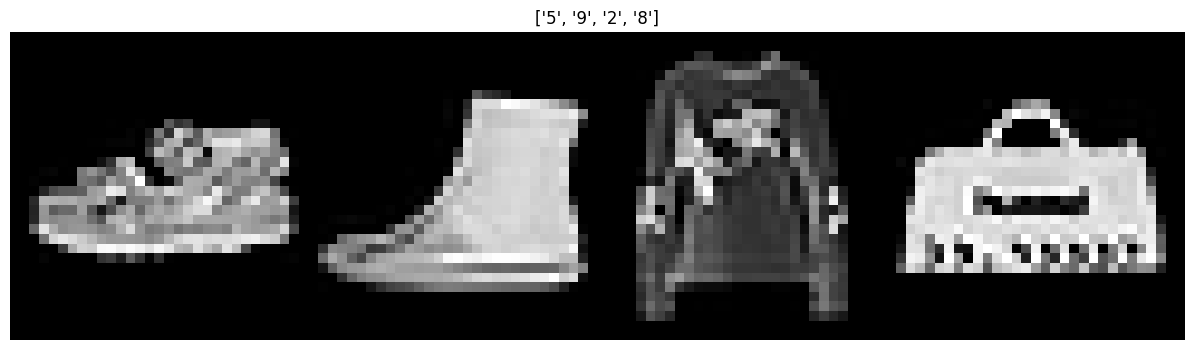

In [10]:
images, labels = show_batch_images(trainloader)

가장 상위에 표시된 숫자는 클래스(레이블)를 의미하며 그 내용은 다음과 같음


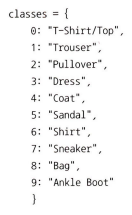

또한 네 개의 이미지가 출력되는 이유는 한 번의 배치에서 네 개의 이미지만 가져오도록 했기 때문

In [11]:
class NormalNet(nn.Module):
    def __init__(self):
        super(NormalNet, self).__init__()
        self.classifier = nn.Sequential(
            nn.Linear(784, 48),  # 28 x 28 = 784 : 입력의 크기
            nn.ReLU(),
            nn.Linear(48, 24),
            nn.ReLU(),
            nn.Linear(24, 10) # FashionMNIST의 클래스는 총 열 개
        ) # nn.Sequential을 사용하면 forward() 함수에서 계층(layer)별로 가독성 있게 코드 구현이 가능

    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = self.classifier(x) # nn.Sequential에서 정의한 계층 호출
        return x

In [12]:
# 배치 정규화가 포함된 네트워크

class BNNet(nn.Module):
    def __init__(self):
        super(BNNet, self).__init__()
        self.classifier = nn.Sequential(
            nn.Linear(784, 48),
            nn.BatchNorm1d(48),
            nn.ReLU(),
            nn.Linear(48, 24),
            nn.BatchNorm1d(24),
            nn.ReLU(),
            nn.Linear(24, 10)
        )

    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

`nn.BatchNorm1d(48)`

배치 정규화가 적용되는 부분

BatchNorm1d에서 사용되는 파라미터는 특성 개수로 이전 계층의 출력 채널이 됨



**배치 정규화를 사용하는 이유** : 은닉층에서 학습이 진행될 때마다 입력 분포가 변하면서 **가중치가 엉뚱한 방향으로 갱신되는 문제**가 종종 발생하기 때문

신경망의 층이 깊어질 수록 학습할 때 가정했던 입력 분포가 변화하여 엉뚱한 학습이 진행될 수 있는대 배치 정규화를 적용해서 입력 분포를 고르게 맞추어 줄 수 있음

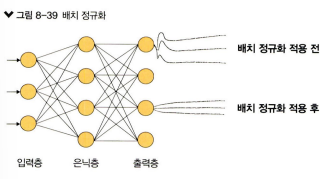


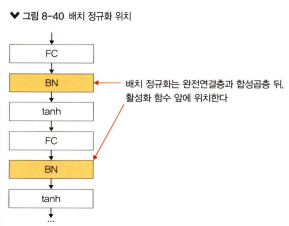

In [13]:
model = NormalNet().to(device)
print(model)

NormalNet(
  (classifier): Sequential(
    (0): Linear(in_features=784, out_features=48, bias=True)
    (1): ReLU()
    (2): Linear(in_features=48, out_features=24, bias=True)
    (3): ReLU()
    (4): Linear(in_features=24, out_features=10, bias=True)
  )
)


In [14]:
# 배치 정규화가 적용된 모델 선언
model_bn = BNNet().to(device)
print(model_bn)

BNNet(
  (classifier): Sequential(
    (0): Linear(in_features=784, out_features=48, bias=True)
    (1): BatchNorm1d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=48, out_features=24, bias=True)
    (4): BatchNorm1d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): Linear(in_features=24, out_features=10, bias=True)
  )
)


In [15]:
batch_size = 512 # 학습을 위한 용도로 배치 크기를 512로 지정
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True)

In [17]:
loss_fn = nn.CrossEntropyLoss().to(device)
opt = optim.SGD(model.parameters(), lr=0.01)
opt_bn = optim.SGD(model_bn.parameters(), lr=0.01)

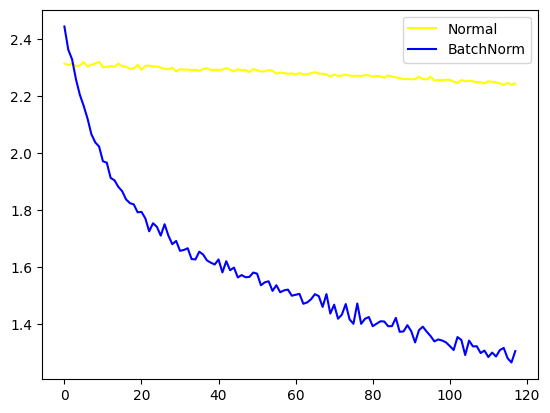

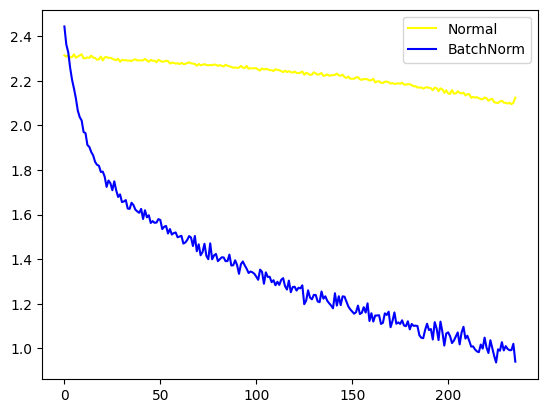

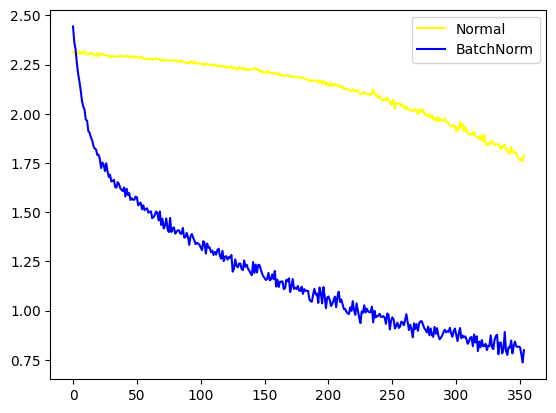

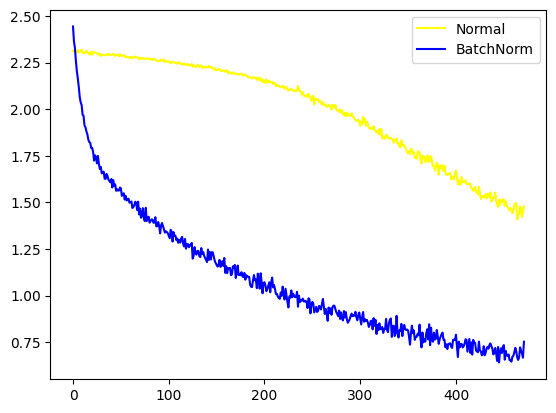

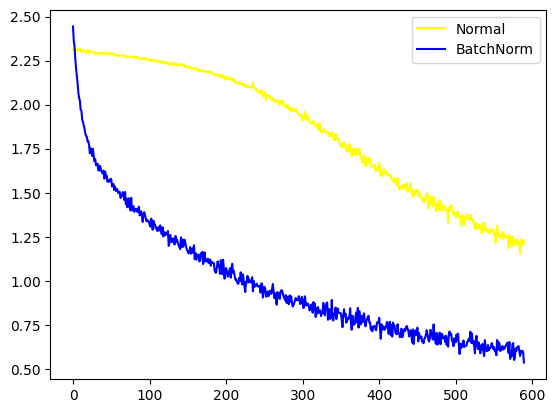

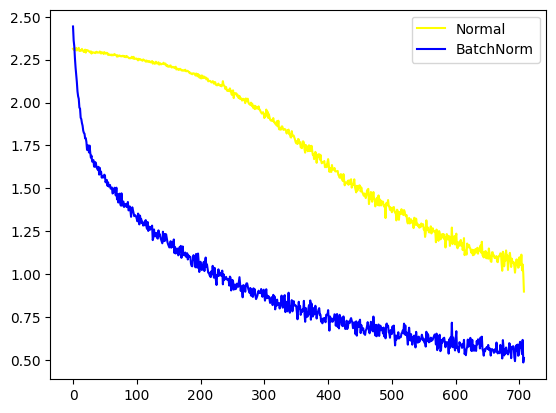

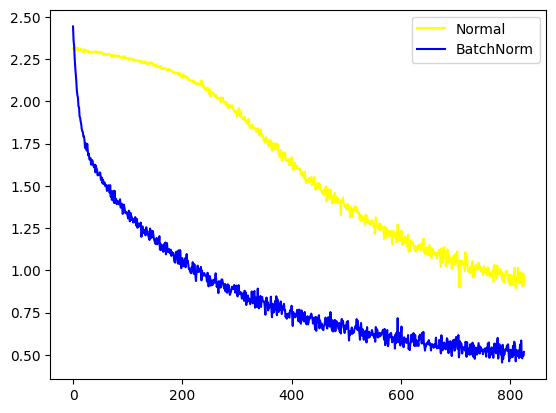

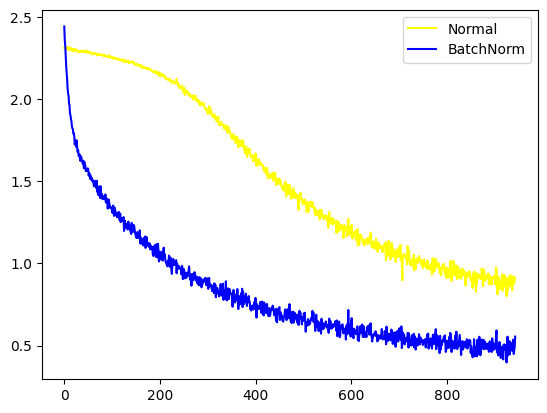

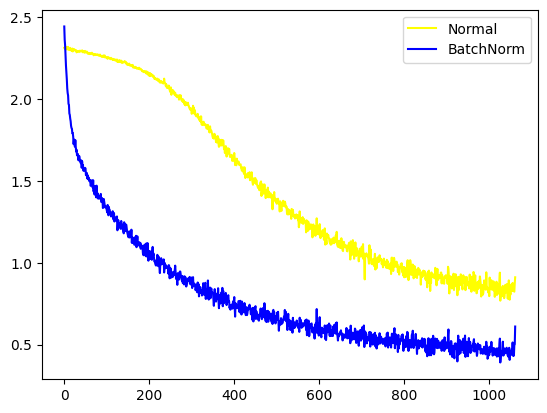

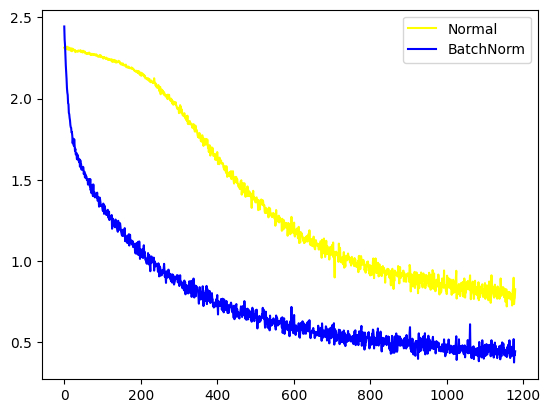

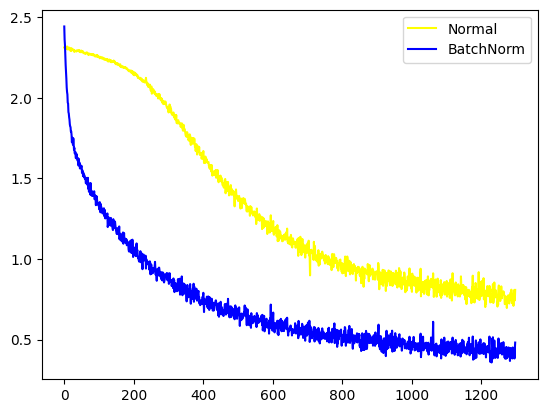

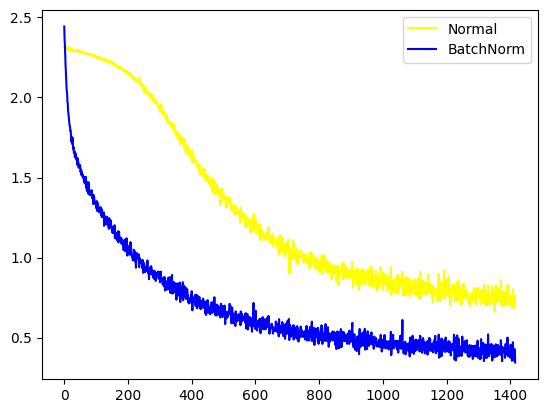

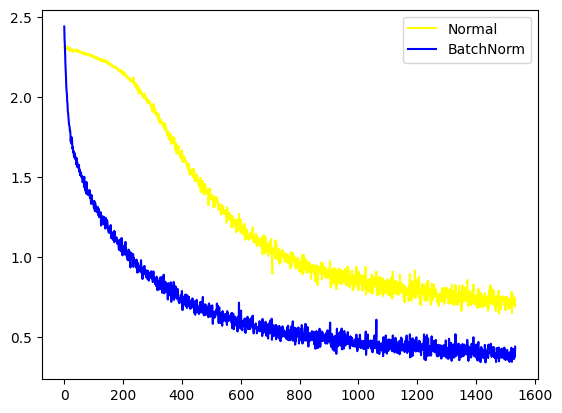

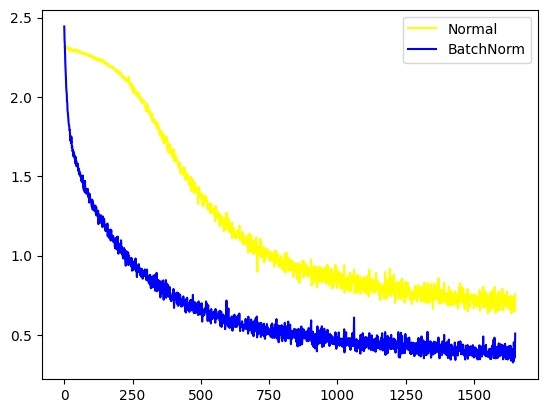

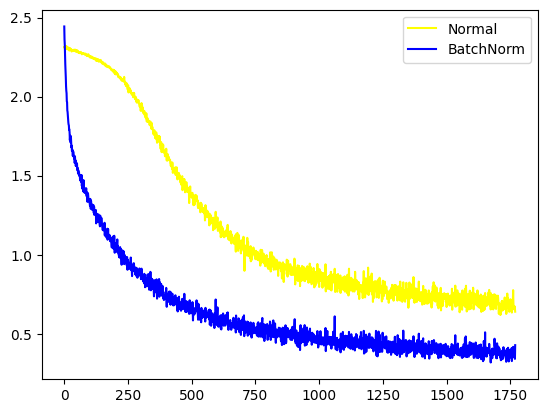

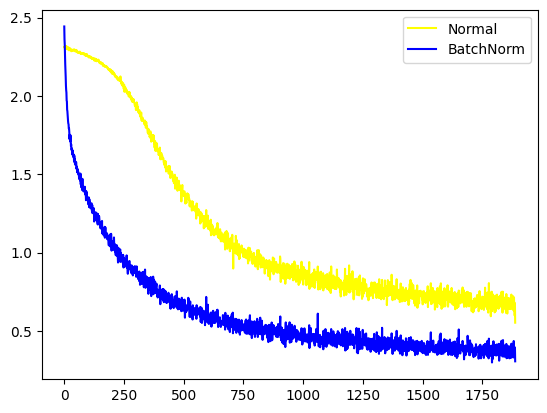

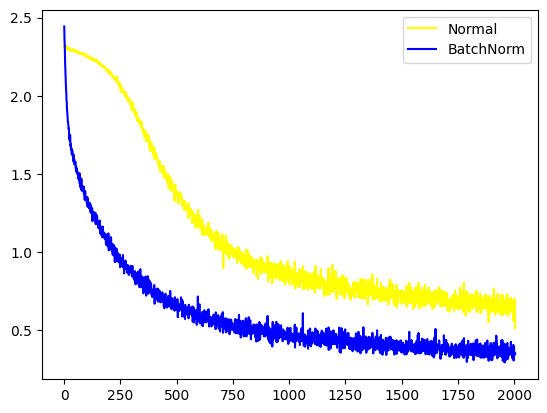

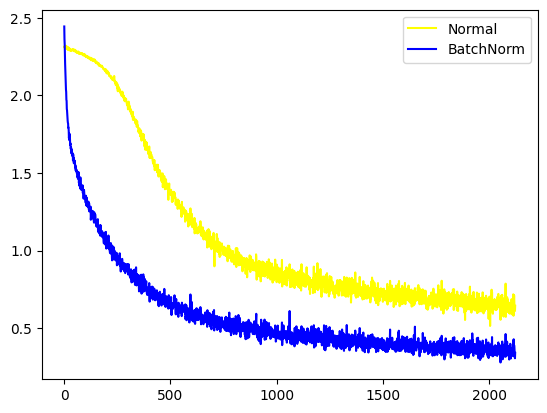

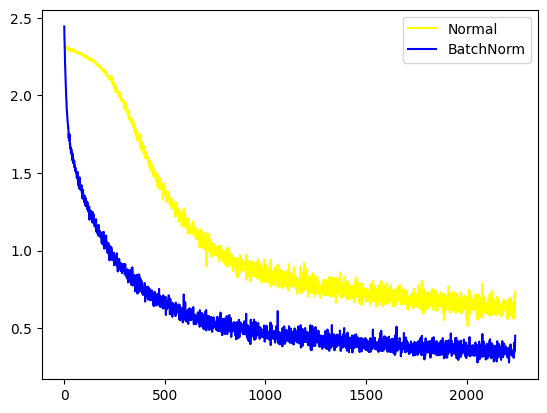

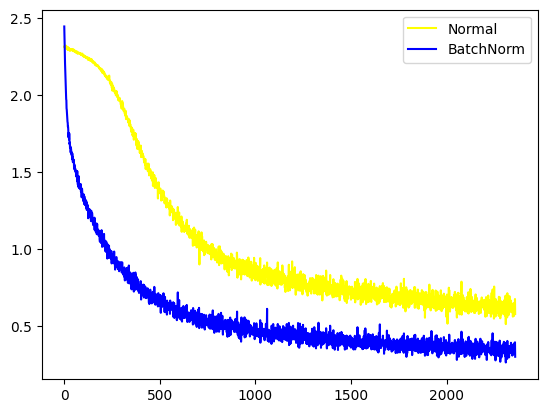

In [18]:
loss_arr = []
loss_bn_arr = []
max_epochs = 20

for epoch in range(max_epochs):
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        opt.zero_grad() # 배치 정규화가 적용되지 않은 모델의 학습
        outputs = model(inputs).to(device)
        loss = loss_fn(outputs, labels)
        loss.backward()
        opt.step()

        opt_bn.zero_grad() # 배치 정규화가 적용된 모델의 학습
        outputs_bn = model_bn(inputs)
        loss_bn = loss_fn(outputs_bn, labels)
        loss_bn.backward()
        opt_bn.step()

        loss_arr.append(loss.item())
        loss_bn_arr.append(loss_bn.item())

    plt.plot(loss_arr, 'yellow', label='Normal')
    plt.plot(loss_bn_arr, 'blue', label='BatchNorm')
    plt.legend()
    plt.show()

배치 정규화가 적용된 모델과 적용되지 않은 모델 모두 시간이 흐를수록 오차가 줄어드는 것을 확인할 수 있음

△ 오차가 줄어드는 범위 및 값의 차이는 명백함

= **배치 정규화가 적용된 모델**의 경우 **더 낮은 값으로 안정적인 범위 내에서 줄어들고 있는 것**을 확인할 수 있음

= **배치 정규화가 적용된 모델**은 **에포크가 진행될수록 오차도 줄어들면서 안정적인 학습**을 하고 있다고 할 수 있음

In [19]:
N = 50
noise = 0.3

x_train = torch.unsqueeze(torch.linspace(-1, 1, N), 1)
y_train = x_train + noise * torch.normal(torch.zeros(N, 1), torch.ones(N, 1))

x_test = torch.unsqueeze(torch.linspace(-1, 1, N), 1)
y_test = x_test + noise * torch.normal(torch.zeros(N, 1), torch.ones(N, 1))

`x_train = ②torch.unsqueeze(①torch.linspace(-1, 1, N), 1)`

훈련 데이터셋이 -1 ~ 1의 값을 갖도록 조정함

① `torch.linspace` : 주어진 범위에서 균등한 값을 갖는 텐서를 만들기 위해 사용하는 것으로, `torch.linspace(-1, 1, N)`의 의미는 -1 ~ 1 범위에서 N개의 균등한 값을 갖는 텐서를 생성하겠다는 것

② `torch.unsqueeze` : 차원을 늘리기 위해 사용하는 것으로, `torch.unsqueeze(torch.linspace(-1, 1, N), 1)`의 의미는 `torch.linspace(-1, 1, N)` 텐서의 첫 번째 자리에 차원을 증가시키겠다는 것

---

`y_train = x_train + noise * ①torch.normal(②torch.zeros(N, 1), ③torch.ones(N, 1))`

훈련 데이터셋 값의 범위가 정규분포를 갖도록 조정함

① `torch.normal` : 정규분포로부터 무작위 표본 추출을 위해 사용하는 것으로, torch.normal(평균,표준편차)를 의미하기 때문에 `torch.zeros()`는 평균, `torch,ones()`는 표준편차를 의미하며, 평균은 0, 표준편차는 1이 기본값

② `torch.zeros` : 0 값을 갖는 N x 1 텐서 생성

③ `torch.ones` : 1 값을 갖는 N x 1 텐서 생성

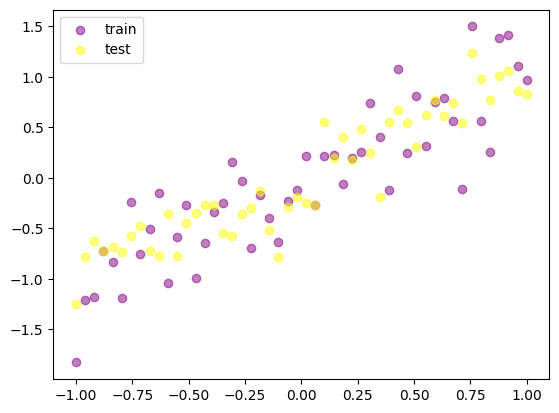

In [20]:
plt.scatter(x_train.data.numpy(), y_train.data.numpy(), c='purple', alpha=0.5, label='train')
plt.scatter(x_test.data.numpy(), y_test.data.numpy(), c='yellow', alpha=0.5, label='test')
plt.legend()
plt.show()

`plt.scatter(①x_train.data.numpy(), ②y_train.data.numpy(), ③c='purple', ④alpha=0.5, ⑤label='train')`

`plt.scatter()`는 데이터를 그래프상에 점으로 출력해서 데이터 분포를 확인하고자 할 때 사용

① 첫 번재 파라미터 : x축에 위치할 데이터

② 두 번째 파라미터 : y축에 위치할 데이터

③ c : 그래프로 출력되는 마커의 색상

④ alpha : 마커에 대한 투명도를 조절하는 것으로 1이면 완전 불투명 상태를 의미

⑤ label : 맷플롯립의 레전드와 같은 역할을 하지만 plt.legend()와 함께 사용되어야 함

→ 훈련과 테스트 데이터가 고르게 분포되어 있음

In [21]:
N_h = 100
model = torch.nn.Sequential(
    torch.nn.Linear(1, N_h),
    torch.nn.ReLU(),
    torch.nn.Linear(N_h, N_h),
    torch.nn.ReLU(),
    torch.nn.Linear(N_h, 1),
) # 드롭아웃이 적용되지 않은 모델

model_dropout = torch.nn.Sequential(
    torch.nn.Linear(1, N_h),
    torch.nn.Dropout(0.2),
    torch.nn.ReLU(),
    torch.nn.Linear(N_h, N_h),
    torch.nn.Dropout(0.2),
    torch.nn.ReLU(),
    torch.nn.Linear(N_h, 1),
) # 드롭아웃이 적용된 모델

In [22]:
opt = torch.optim.Adam(model.parameters(), lr=0.01)
opt_dropout = torch.optim.Adam(model_dropout.parameters(), lr=0.01)
loss_fn = torch.nn.MSELoss().to(device)

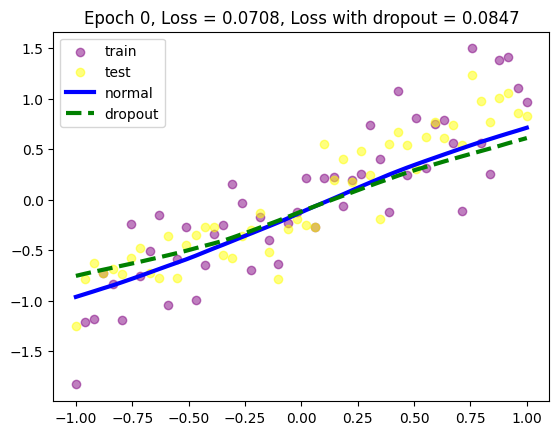

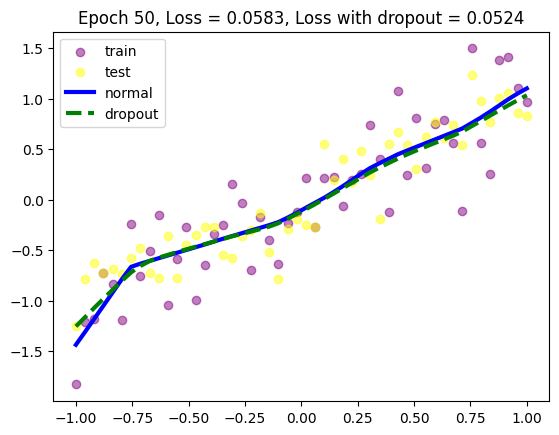

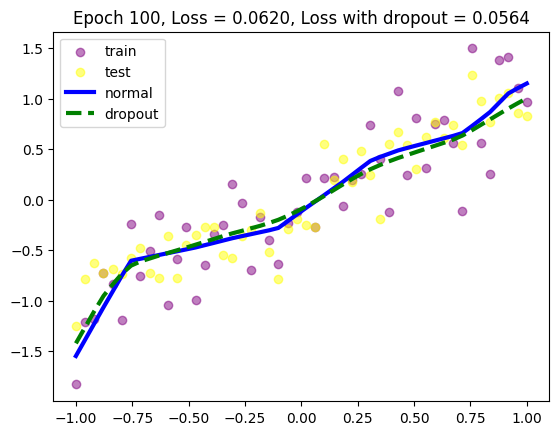

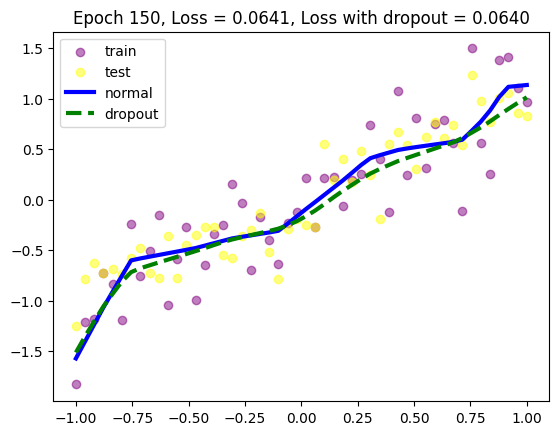

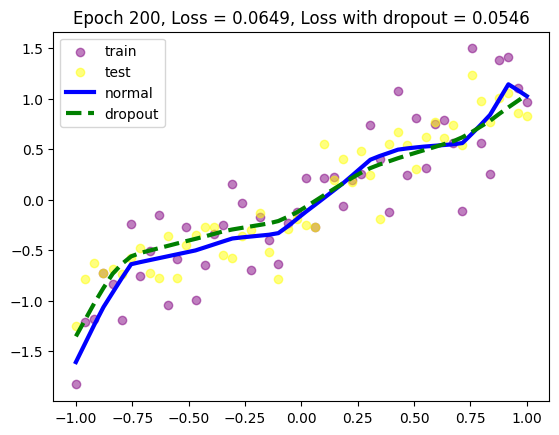

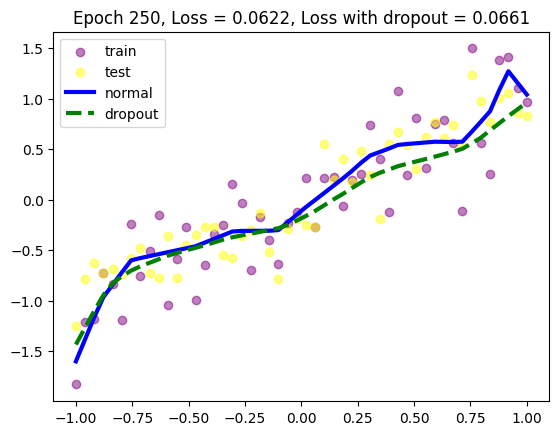

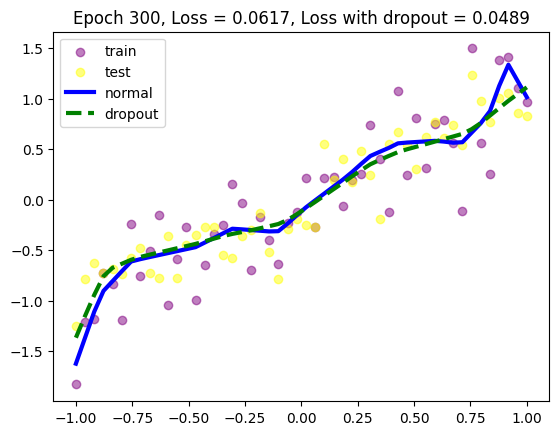

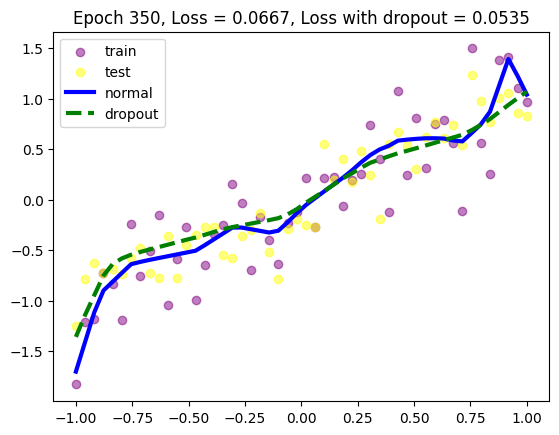

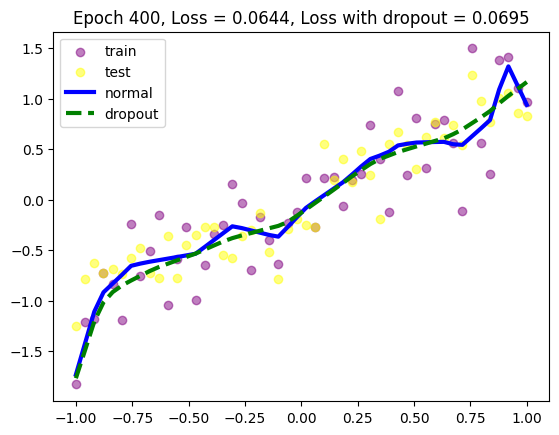

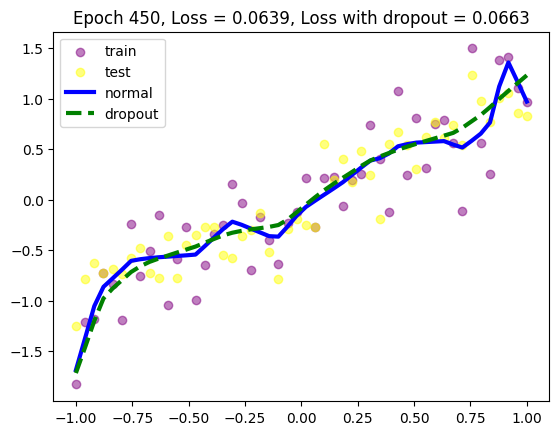

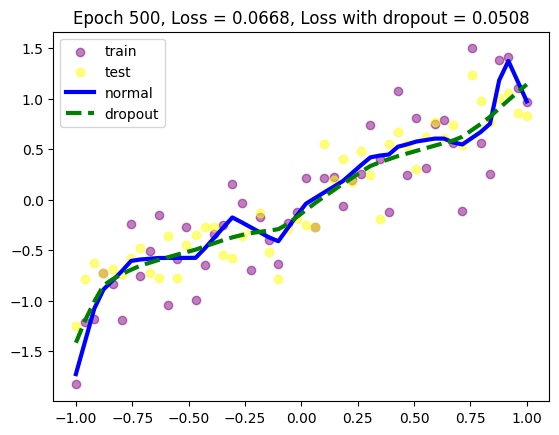

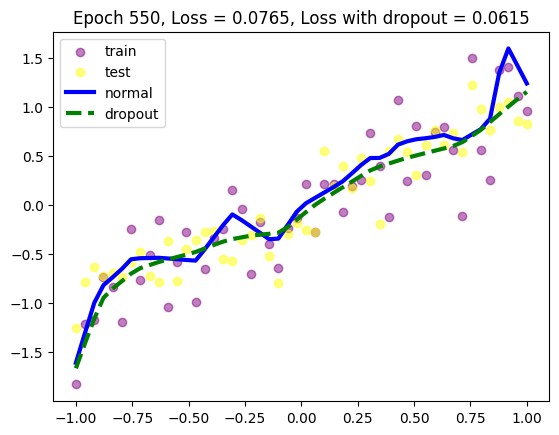

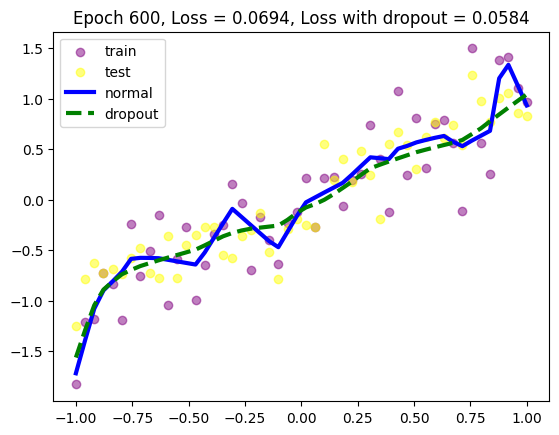

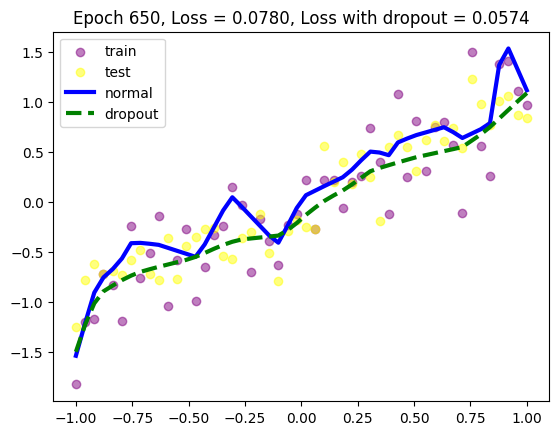

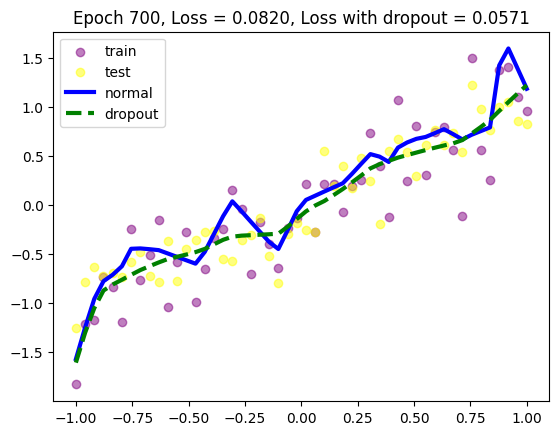

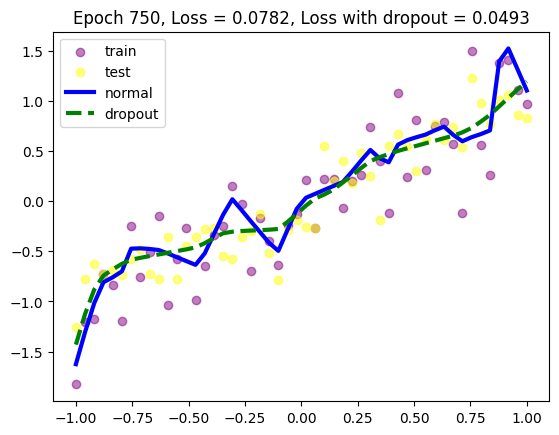

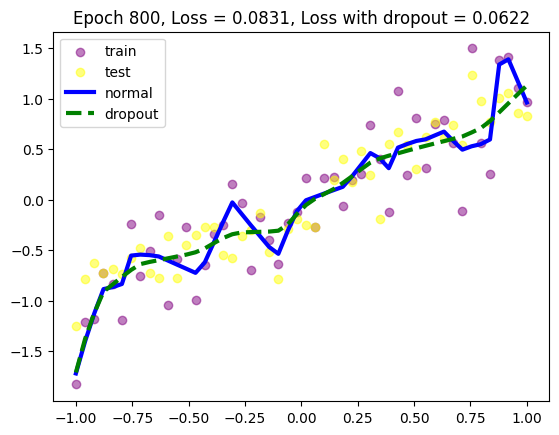

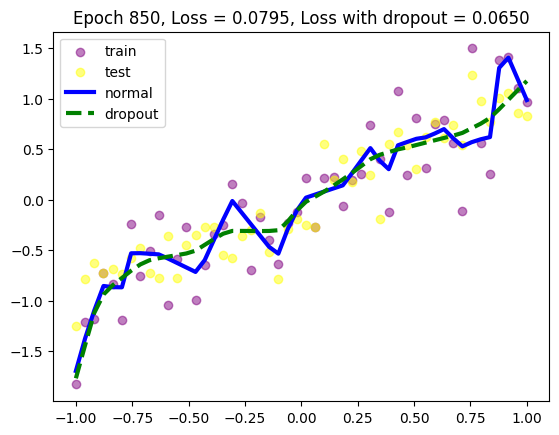

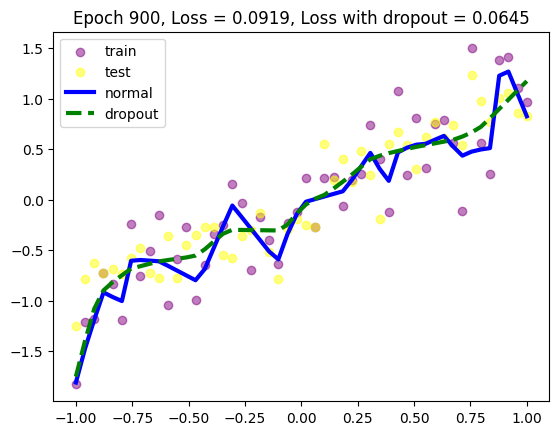

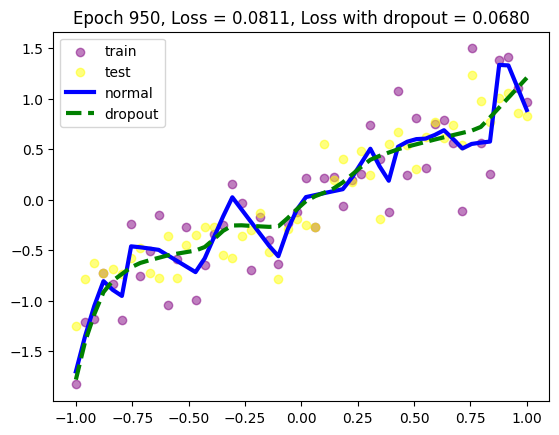

In [23]:
max_epochs = 1000
for epoch in range(max_epochs):
    pred = model(x_train) # 드롭아웃이 적용되지 않은 모델 학습
    loss = loss_fn(pred, y_train)
    opt.zero_grad()
    loss.backward()
    opt.step()

    pred_dropout = model_dropout(x_train) # 드롭아웃이 적용된 모델 학습
    loss_dropout = loss_fn(pred_dropout, y_train)
    opt_dropout.zero_grad()
    loss_dropout.backward()
    opt_dropout.step()

    if epoch % 50 == 0: # epoch를 50으로 나눈 나머지가 0이면 다음 진행
        model.eval()
        model_dropout.eval()

        test_pred = model(x_test)
        test_loss = loss_fn(test_pred, y_test)

        test_pred_dropout = model_dropout(x_test)
        test_loss_dropout = loss_fn(test_pred_dropout, y_test)

        plt.scatter(x_train.data.numpy(), y_train.data.numpy(), c='purple', alpha=0.5, label='train')
        plt.scatter(x_test.data.numpy(), y_test.data.numpy(), c='yellow', alpha=0.5, label='test')
        plt.plot(x_test.data.numpy(), test_pred.data.numpy(), 'b-', lw=3, label='normal') # 파란색 실선으로 x축은 테스트 데이터셋, y축은 드롭아웃이 적용되지 않은 모델의 결과를 그래프로 출력
        plt.plot(x_test.data.numpy(), test_pred_dropout.data.numpy(), 'g--', lw=3,  label='dropout') # 초록색 점선으로 x축은 테스트 데이터셋, y축은 드롭아웃이 적용된 모델의 결과를 그래프로 출력

        plt.title('Epoch %d, Loss = %0.4f, Loss with dropout = %0.4f' % (epoch, test_loss, test_loss_dropout)) # 에포크, 드롭아웃이 적용되지 않은 모델의 오차, 드롭아웃이 적용된 모델의 오차를 타이틀로 출력
        plt.legend()
        model.train()
        model_dropout.train()
        plt.pause(0.05)

전반적으로 오차가 줄어드는 범위가 크지 않음 **△ 드롭아웃을 적용했을 때의 오차가 더 낮은 것을 확인할 수 있음**

출력 결과에서 초록색 점선과 파란색 실선의 차이가 크지 않아 보일 수 있지만 이 정도면 **실제로는 큰 차이**가 있는 상태

**훈련 횟수가 늘어날수록 파란색 실선은 가장자리의 자주색 점들을 찾아가고 있음**

문제는 **자주잭 점이 훈련 데이터셋을 의미**한다는 것이고, 이것은 다른 의미로 **과적합 현상을 보이고 있다**는 것임

이와 같이 과적합 현상을 방지하기 위해 **드롭아웃**을 사용하며, 초록색 점선 그래프에서는 과적합 현상이 발생하지 않는 것을 확인할 수 있음

# 8.3.3 조기종료

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models # 사전 학습된 모델을 이용하고자 할 때 사용하는 라이브러리
from torchvision import transforms, datasets

import matplotlib
import matplotlib.pyplot as plt
import time
import argparse
from tqdm import tqdm
matplotlib.style.use('ggplot') # 출력 그래프에서 격자로 숫자 범위가 눈에 잘 띄도록 하는 스타일

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
train_transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomVerticalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225])
    ])
val_transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225])
    ])

In [ ]:
import zipfile

# 업로드한 ZIP 파일 이름
zip_file_name = "archive.zip"  # 업로드한 ZIP 파일의 이름으로 변경

# ZIP 파일을 현재 디렉토리에 풀기
with zipfile.ZipFile(zip_file_name, 'r') as zip_ref:
    zip_ref.extractall()  # ZIP 파일을 현재 디렉토리에 추출

In [ ]:
train_dataset = datasets.ImageFolder(
    root=r'/content/train',
    transform=train_transform
)
train_dataloader = torch.utils.data.DataLoader(
    train_dataset, batch_size=32, shuffle=True,
)
val_dataset = datasets.ImageFolder(
    root=r'/content/test',
    transform=val_transform
)
val_dataloader = torch.utils.data.DataLoader(
    val_dataset, batch_size=32, shuffle=False,
)

In [ ]:
def resnet50(pretrained=True):
    model = models.resnet50(progress=True, pretrained=pretrained)
    if requires_grad == False: # 파라미터를 고정하여 backward() 중에 기울기가 계산되지 않도록 함. requires_grad=False를 파라미터로 받으면 해당 구문이 실행됨
        for param in model.parameters():
            param.requires_grad = False
    elif requires_grad == True: # 파라미터 값이 backward()중에 기울기 계산에 반영됨
        for param in model.parameters():
            param.requires_grad = True
    model.fc = nn.Linear(2048, 2) # 마지막 분류를 위한 계층은 학습을 진행함
    return model

네트워크를 직접 구축하는 것이 아닌 사전 학습된 ResNet50 사용

In [ ]:
class LRScheduler():
    def __init__(
        self, optimizer, patience=5, min_lr=1e-6, factor=0.5
    ):
        self.optimizer = optimizer
        self.patience = patience
        self.min_lr = min_lr
        self.factor = factor
        self.lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
                self.optimizer,
                mode='min',
                patience=self.patience,
                factor=self.factor,
                min_lr=self.min_lr,
                verbose=True
            )
    def __call__(self, val_loss):
        self.lr_scheduler.step(val_loss)

파이토치에서 조기 종료와 함께 자주 사용되는 것으로 학습률 감소(learning rate decay)라는 것이 있음

학습률에 대한 값을 고정시켜서 모델을 학습시키는 것이 아니라 학습이 진행되는 과정에서 학습률을 조금씩 낮추어 주는 성능 튜닝 기법 중 하나

학습률 감소는 학습률 스케줄러라는 것을 사용하는데, 주어진 patience 횟수만큼 검증 데이터셋에 대한 오차 감소가 없으면 역시 주어진 'factor'만큼 학습률을 감소시켜서 모델 학습의 최적화가 가능하도록 도와줌

`torch.optim.①lr_scheduler.ReduceLROnPlateau(②self.optimizer,③mode='min',④patience=self.patience,⑤factor=self.factor,⑥min_lr=self.min_lr,⑦verbose=True)`

학습과정에서 모델 성능에 대한 개선이 없을 경우 학습률 값을 조절하여 모델의 개선을 유도하는 콜백 함수

① `lr_scheduler.ReduceLROnPlateau` : 검증 데이터셋에 대한 오차의 변동이 없으면 학습률을 factor배로 감소시킴

② `optimizer` : 파라미터(가중치)를 갱신시키는 부분으로, 여기에서는 아담을 사용

③ `mode` : 언제 학습률을 조정할지에 대한 기준이 되는 값으로, 모델의 정확도로 사용하면 max를 지정하고, 모델의 오차로 사용할 경우 작을 수록 좋기 때문에 min을 지정함

④ `patience` : 학습률을 업데이트하기 전에 몇 번의 에포크를 기다려야 하는지 결정

⑤ `factor` : 학습률을 얼마나 감소시킬지 지정하는 파라미터로, 새로운 학습률은 기존 학습률 * factor가 됨

⑥ `min_lr` : 학습률의 하한선을 지정

⑦ `verbose` : 조기 종료의 시작과 끝을 출력하기 위해 사용함


Note | **콜백 함수(callback)**

개발자가 명시적으로 함수를 호출하는 것이 아니라 개발자는 단지 함수 등록만 하고 특정 이벤트 발생에 의해 함수를 호출하고 처리하도록 하는 것이 콜백 함수

콜백 함수로는 **동기적(synchronous) 함수**와 **비동기적(asynchronous) 함수**가 있음

**동기적 함수**는 코드가 위에서 아래로, 왼쪽에서 오른쪽으로 **순차적으로 실행되는 함수**

**비동기 함수**는 병렬 처리와 같이 어떤 코드를 실행했을 때 상당한 시간을 기다려야 하는 경우 해당 코드가 완료될 때까지 기다리는 것이 아닌 **다른 코드가 먼저 처리되도록 하는 것**이 비동기 함수

`self.lr_scheduler.step(val_loss)`

실제로 학습률을 업데이트

에포크 단위로 검증 데이터셋에 대한 오차를 받아서 이전 오차와 비교했을 때 차이가 없다면 학습률을 업데이트

In [ ]:
class EarlyStopping():
    def __init__(self, patience=5, verbose=False, delta=0, path='../checkpoint.pt'):
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None # 검증 데이터셋에 대한 오차 최적화 값(오차가 가장 낮은 값)
        self.early_stop = False # 조기 종료를 의미하며 초깃값은 False로 설정
        self.val_loss_min = np.inf # np.inf(infinity)는 넘파이에서 무한대를 표현
        self.delta = delta
        self.path = path # 모델이 저장될 경로

    def __call__(self, val_loss, model): # 에포크만큼 학습이 반복되면서 best_loss가 갱신되고, best_loss에 진전이 없으면 조기 종료한 후 모델을 저장
        score = -val_loss

        if self.best_score is None: # best_score에 값이 존재하지 않으면 실행
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta: # best_score + delta가 score보다 크면 실행
            self.counter += 1
            print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else: # 그 외 모든 경우에 실행
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model): # 검증 데이터셋에 대한 오차가 감소하면 모델을 저장
        if self.verbose:
            print(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        torch.save(model.state_dict(), self.path) # 지정된 경로에 모델 저장
        self.val_loss_min = val_loss

① `patience` : 오차 개선이 없다고 바로 종료하지 않고 개선이 없는 에포크를 얼마나 기다려 줄지 지정

② `delta` : 오차가 개선되고 있다고 판단하기 위한 최소 변화량을 나타냄

케라스에서 제공하는 콜백(keras.callback)을 이용하면 손쉽게 조기 종료를 구현할 수 있지만 파이토치에서는 조기 종료 함수 자체를 사용자가 직접 구현해야 함

In [ ]:
parser = argparse.ArgumentParser() # 인수 값을 받을 수 있는 인스턴스 생성
parser.add_argument('--lr-scheduler', dest='lr_scheduler', action='store_true')
parser.add_argument('--early-stopping', dest='early_stopping', action='store_true') # 조기 종료에 대한 인수
parser.add_argument("-f", "--fff", help="a dummy argument to fool ipython", default="1") #주피터 노트북에서 실행할때 필요합니다
args = vars(parser.parse_args())

**학습률 감소**와 **조기 종료** 두 개에 대한 **성능 튜닝** 진행

= 함수에 넘겨주는 **인수(argument) 값에 따라 다른 동작을 하도록 해야 함**

→ 이 때 사용할 수 있는 것이 **argparse 라이브러리**

ArgumentParser()를 이용하여 변수와 타입을 정의해주고 add_argument()를 이용해서 변수에 인수 값을 하나씩 추가함

마지막으로 parse_args()를 통해 사용자로부터 입력받은 값들을 args 변수에 저장함

`parser.add_argument(①'--lr-scheduler', ②dest='lr_scheduler', ③action='store_true')`

원하는 인수 값을 추가함. 이때 parser.add_argument()는 인수 개수만큼 만들어 줌

① 첫 번째 파라미터 : 옵션 문자열의 이름으로 명령을 실행할 때 사용

② `dest` : 입력 값이 저장되는 변수

③ `action` : action을 store_true로 지정하면 입력 값을 dest 파라미터에 의해 생성된 변수에 저장함

---

`args = vars(parser.parse_args())`

입력받은 인수 값이 실제로 args 변수에 저장됨

In [ ]:
print(f"Computation device: {device}\n") # CPU를 사용하는지 GPU를 사용하는지 검사
model = models.resnet50(weights='DEFAULT').to(device) # 사전 훈련된 ResNet50 사용
total_params = sum(p.numel() for p in model.parameters()) # 총 파라미터 수
print(f"{total_params:,} total parameters.")
total_trainable_params = sum(
    p.numel() for p in model.parameters() if p.requires_grad) # 학습 가능한 파라미터 수
print(f"{total_trainable_params:,} training parameters.")

Computation device: cuda



Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 147MB/s]


25,557,032 total parameters.
25,557,032 training parameters.


In [ ]:
lr = 0.001
epochs = 100
optimizer = optim.Adam(model.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()

In [ ]:
loss_plot_name = 'loss' # 오차 출력에 대한 문자열
acc_plot_name = 'accuracy' # 정확도 출력에 대한 문자열
model_name = 'model' # 모델을 저장하기 위한 문자열

In [ ]:
if args['lr_scheduler']:
    print('INFO: Initializing learning rate scheduler')
    lr_scheduler = LRScheduler(optimizer)
    loss_plot_name = 'lrs_loss' # 학습률 감소를 적용했을 때의 오차에 대한 문자열
    acc_plot_name = 'lrs_accuracy' # 학습률 감소를 적용했을 때의 정확도에 대한 문자열
    model_name = 'lrs_model' # 학습률 감소를 적용했을 때의 모델에 대한 문자열
if args['early_stopping']:
    print('INFO: Initializing early stopping')
    early_stopping = EarlyStopping()
    loss_plot_name = 'es_loss' # 조기 종료를 적용했을 때의 오차에 대한 문자열
    acc_plot_name = 'es_accuracy' # 조기 종료를 적용했을 때의 정확도에 대한 문자열
    model_name = 'es_model' # 조기 종료를 적용했을 때의 모델에 대한 문자열

In [ ]:
def training(model, train_dataloader, train_dataset, optimizer, criterion):
    print('Training')
    model.train()
    train_running_loss = 0.0
    train_running_correct = 0
    counter = 0
    total = 0
    prog_bar = tqdm(enumerate(train_dataloader), total=int(len(train_dataset)/train_dataloader.batch_size)) # 훈련 진행 과정을 시각적으로 표현
    for i, data in prog_bar:
        counter += 1
        data, target = data[0].to(device), data[1].to(device)
        total += target.size(0)
        optimizer.zero_grad()
        outputs = model(data)
        loss = criterion(outputs, target)
        train_running_loss += loss.item()
        _, preds = torch.max(outputs.data, 1)
        train_running_correct += (preds == target).sum().item()
        loss.backward()
        optimizer.step()

    train_loss = train_running_loss / counter
    train_accuracy = 100. * train_running_correct / total
    return train_loss, train_accuracy

In [ ]:
def validate(model, test_dataloader, val_dataset, criterion):
    print('Validating')
    model.eval()
    val_running_loss = 0.0
    val_running_correct = 0
    counter = 0
    total = 0
    prog_bar = tqdm(enumerate(test_dataloader), total=int(len(val_dataset)/test_dataloader.batch_size)) # 모델 검증 과정을 시각적으로 표현
    with torch.no_grad():
        for i, data in prog_bar:
            counter += 1
            data, target = data[0].to(device), data[1].to(device)
            total += target.size(0)
            outputs = model(data)
            loss = criterion(outputs, target)

            val_running_loss += loss.item()
            _, preds = torch.max(outputs.data, 1)
            val_running_correct += (preds == target).sum().item()

        val_loss = val_running_loss / counter
        val_accuracy = 100. * val_running_correct / total
        return val_loss, val_accuracy

In [ ]:
train_loss, train_accuracy = [], []
val_loss, val_accuracy = [], []
start = time.time()
for epoch in range(epochs):
    print(f"Epoch {epoch+1} of {epochs}")
    train_epoch_loss, train_epoch_accuracy = training(
        model, train_dataloader, train_dataset, optimizer, criterion
    )
    val_epoch_loss, val_epoch_accuracy = validate(
        model, val_dataloader, val_dataset, criterion
    )
    train_loss.append(train_epoch_loss)
    train_accuracy.append(train_epoch_accuracy)
    val_loss.append(val_epoch_loss)
    val_accuracy.append(val_epoch_accuracy)
    if args['lr_scheduler']:
        lr_scheduler(val_epoch_loss)
    if args['early_stopping']:
        early_stopping(val_epoch_loss, model)
        if early_stopping.early_stop:
            break
    print(f"Train Loss: {train_epoch_loss:.4f}, Train Acc: {train_epoch_accuracy:.2f}")
    print(f'Val Loss: {val_epoch_loss:.4f}, Val Acc: {val_epoch_accuracy:.2f}')
end = time.time()
print(f"Training time: {(end-start)/60:.3f} minutes")

Epoch 1 of 100
Training


16it [00:06,  2.43it/s]


Validating


16it [00:03,  4.16it/s]


Train Loss: 1.9676, Train Acc: 61.24
Val Loss: 0.5841, Val Acc: 75.80
Epoch 2 of 100
Training


16it [00:04,  3.56it/s]


Validating


16it [00:03,  4.72it/s]


Train Loss: 0.3215, Train Acc: 87.95
Val Loss: 0.5330, Val Acc: 81.00
Epoch 3 of 100
Training


16it [00:04,  3.36it/s]


Validating


16it [00:03,  4.71it/s]


Train Loss: 0.2352, Train Acc: 89.96
Val Loss: 0.6586, Val Acc: 78.80
Epoch 4 of 100
Training


16it [00:04,  3.49it/s]


Validating


16it [00:03,  4.11it/s]


Train Loss: 0.2882, Train Acc: 88.76
Val Loss: 0.6402, Val Acc: 76.60
Epoch 5 of 100
Training


16it [00:04,  3.50it/s]


Validating


16it [00:03,  4.75it/s]


Train Loss: 0.2163, Train Acc: 90.16
Val Loss: 0.7770, Val Acc: 78.40
Epoch 6 of 100
Training


16it [00:04,  3.33it/s]


Validating


16it [00:03,  4.75it/s]


Train Loss: 0.1795, Train Acc: 93.57
Val Loss: 0.7727, Val Acc: 78.20
Epoch 7 of 100
Training


16it [00:04,  3.44it/s]


Validating


16it [00:03,  4.05it/s]


Train Loss: 0.1454, Train Acc: 94.18
Val Loss: 0.8144, Val Acc: 76.40
Epoch 8 of 100
Training


16it [00:04,  3.43it/s]


Validating


16it [00:03,  4.68it/s]


Train Loss: 0.1309, Train Acc: 95.78
Val Loss: 0.5597, Val Acc: 78.80
Epoch 9 of 100
Training


16it [00:04,  3.29it/s]


Validating


16it [00:03,  4.73it/s]


Train Loss: 0.2184, Train Acc: 91.97
Val Loss: 0.5438, Val Acc: 82.40
Epoch 10 of 100
Training


16it [00:04,  3.38it/s]


Validating


16it [00:03,  4.10it/s]


Train Loss: 0.1329, Train Acc: 94.78
Val Loss: 0.6456, Val Acc: 76.80
Epoch 11 of 100
Training


16it [00:04,  3.35it/s]


Validating


16it [00:03,  4.58it/s]


Train Loss: 0.1170, Train Acc: 94.78
Val Loss: 0.6631, Val Acc: 77.80
Epoch 12 of 100
Training


16it [00:04,  3.20it/s]


Validating


16it [00:03,  4.67it/s]


Train Loss: 0.0586, Train Acc: 97.59
Val Loss: 0.4752, Val Acc: 83.80
Epoch 13 of 100
Training


16it [00:04,  3.27it/s]


Validating


16it [00:03,  4.42it/s]


Train Loss: 0.0748, Train Acc: 98.19
Val Loss: 0.4992, Val Acc: 86.20
Epoch 14 of 100
Training


16it [00:05,  3.06it/s]


Validating


16it [00:04,  3.36it/s]


Train Loss: 0.0901, Train Acc: 96.79
Val Loss: 0.7275, Val Acc: 80.60
Epoch 15 of 100
Training


16it [00:04,  3.36it/s]


Validating


16it [00:03,  4.69it/s]


Train Loss: 0.0809, Train Acc: 97.39
Val Loss: 0.6165, Val Acc: 80.20
Epoch 16 of 100
Training


16it [00:04,  3.26it/s]


Validating


16it [00:03,  4.61it/s]


Train Loss: 0.0776, Train Acc: 96.99
Val Loss: 0.5815, Val Acc: 82.80
Epoch 17 of 100
Training


16it [00:04,  3.34it/s]


Validating


16it [00:04,  3.98it/s]


Train Loss: 0.0746, Train Acc: 97.59
Val Loss: 0.4785, Val Acc: 84.60
Epoch 18 of 100
Training


16it [00:04,  3.38it/s]


Validating


16it [00:03,  4.64it/s]


Train Loss: 0.0545, Train Acc: 98.19
Val Loss: 1.5122, Val Acc: 72.00
Epoch 19 of 100
Training


16it [00:04,  3.27it/s]


Validating


16it [00:03,  4.70it/s]


Train Loss: 0.0594, Train Acc: 97.99
Val Loss: 0.8121, Val Acc: 78.60
Epoch 20 of 100
Training


16it [00:04,  3.35it/s]


Validating


16it [00:04,  3.99it/s]


Train Loss: 0.0632, Train Acc: 97.79
Val Loss: 0.6503, Val Acc: 81.20
Epoch 21 of 100
Training


16it [00:04,  3.35it/s]


Validating


16it [00:03,  4.67it/s]


Train Loss: 0.0594, Train Acc: 98.19
Val Loss: 0.6958, Val Acc: 80.20
Epoch 22 of 100
Training


16it [00:04,  3.22it/s]


Validating


16it [00:03,  4.66it/s]


Train Loss: 0.0914, Train Acc: 96.79
Val Loss: 0.7079, Val Acc: 83.40
Epoch 23 of 100
Training


16it [00:04,  3.32it/s]


Validating


16it [00:03,  4.13it/s]


Train Loss: 0.0646, Train Acc: 98.39
Val Loss: 0.6799, Val Acc: 83.40
Epoch 24 of 100
Training


16it [00:04,  3.34it/s]


Validating


16it [00:03,  4.59it/s]


Train Loss: 0.0529, Train Acc: 97.79
Val Loss: 0.6729, Val Acc: 81.60
Epoch 25 of 100
Training


16it [00:04,  3.22it/s]


Validating


16it [00:03,  4.71it/s]


Train Loss: 0.0399, Train Acc: 98.80
Val Loss: 0.5711, Val Acc: 84.20
Epoch 26 of 100
Training


16it [00:04,  3.32it/s]


Validating


16it [00:03,  4.44it/s]


Train Loss: 0.0631, Train Acc: 98.19
Val Loss: 0.4885, Val Acc: 86.00
Epoch 27 of 100
Training


16it [00:04,  3.36it/s]


Validating


16it [00:03,  4.32it/s]


Train Loss: 0.0717, Train Acc: 97.39
Val Loss: 0.6028, Val Acc: 81.60
Epoch 28 of 100
Training


16it [00:04,  3.28it/s]


Validating


16it [00:03,  4.68it/s]


Train Loss: 0.1221, Train Acc: 96.79
Val Loss: 0.5902, Val Acc: 83.60
Epoch 29 of 100
Training


16it [00:04,  3.27it/s]


Validating


16it [00:03,  4.66it/s]


Train Loss: 0.1122, Train Acc: 95.78
Val Loss: 0.7102, Val Acc: 81.00
Epoch 30 of 100
Training


16it [00:04,  3.36it/s]


Validating


16it [00:03,  4.12it/s]


Train Loss: 0.0378, Train Acc: 98.39
Val Loss: 0.7320, Val Acc: 81.80
Epoch 31 of 100
Training


16it [00:04,  3.30it/s]


Validating


16it [00:03,  4.67it/s]


Train Loss: 0.0627, Train Acc: 98.19
Val Loss: 0.6981, Val Acc: 81.40
Epoch 32 of 100
Training


16it [00:04,  3.25it/s]


Validating


16it [00:03,  4.69it/s]


Train Loss: 0.0777, Train Acc: 96.99
Val Loss: 0.6057, Val Acc: 84.00
Epoch 33 of 100
Training


16it [00:04,  3.35it/s]


Validating


16it [00:03,  4.02it/s]


Train Loss: 0.0768, Train Acc: 97.39
Val Loss: 0.6703, Val Acc: 80.00
Epoch 34 of 100
Training


16it [00:04,  3.36it/s]


Validating


16it [00:03,  4.68it/s]


Train Loss: 0.0718, Train Acc: 96.79
Val Loss: 0.6187, Val Acc: 84.40
Epoch 35 of 100
Training


16it [00:04,  3.25it/s]


Validating


16it [00:03,  4.67it/s]


Train Loss: 0.0393, Train Acc: 98.59
Val Loss: 0.7000, Val Acc: 83.00
Epoch 36 of 100
Training


16it [00:04,  3.34it/s]


Validating


16it [00:03,  4.01it/s]


Train Loss: 0.0290, Train Acc: 99.00
Val Loss: 0.8744, Val Acc: 84.20
Epoch 37 of 100
Training


16it [00:04,  3.36it/s]


Validating


16it [00:03,  4.66it/s]


Train Loss: 0.0338, Train Acc: 98.80
Val Loss: 1.4487, Val Acc: 76.60
Epoch 38 of 100
Training


16it [00:04,  3.25it/s]


Validating


16it [00:03,  4.63it/s]


Train Loss: 0.0569, Train Acc: 98.39
Val Loss: 0.6292, Val Acc: 83.00
Epoch 39 of 100
Training


16it [00:04,  3.35it/s]


Validating


16it [00:03,  4.11it/s]


Train Loss: 0.0580, Train Acc: 97.79
Val Loss: 0.7140, Val Acc: 83.80
Epoch 40 of 100
Training


16it [00:04,  3.36it/s]


Validating


16it [00:03,  4.66it/s]


Train Loss: 0.0461, Train Acc: 97.99
Val Loss: 0.6261, Val Acc: 83.80
Epoch 41 of 100
Training


16it [00:04,  3.22it/s]


Validating


16it [00:03,  4.68it/s]


Train Loss: 0.0390, Train Acc: 98.19
Val Loss: 0.6359, Val Acc: 83.60
Epoch 42 of 100
Training


16it [00:04,  3.31it/s]


Validating


16it [00:03,  4.23it/s]


Train Loss: 0.1065, Train Acc: 96.39
Val Loss: 0.7492, Val Acc: 78.40
Epoch 43 of 100
Training


16it [00:04,  3.35it/s]


Validating


16it [00:03,  4.36it/s]


Train Loss: 0.1025, Train Acc: 97.19
Val Loss: 0.5348, Val Acc: 81.00
Epoch 44 of 100
Training


16it [00:04,  3.27it/s]


Validating


16it [00:03,  4.74it/s]


Train Loss: 0.0559, Train Acc: 97.59
Val Loss: 0.7793, Val Acc: 83.60
Epoch 45 of 100
Training


16it [00:04,  3.28it/s]


Validating


16it [00:03,  4.50it/s]


Train Loss: 0.0795, Train Acc: 97.39
Val Loss: 1.8085, Val Acc: 67.40
Epoch 46 of 100
Training


16it [00:04,  3.35it/s]


Validating


16it [00:03,  4.22it/s]


Train Loss: 0.1076, Train Acc: 97.39
Val Loss: 0.5399, Val Acc: 82.80
Epoch 47 of 100
Training


16it [00:04,  3.29it/s]


Validating


16it [00:03,  4.70it/s]


Train Loss: 0.0334, Train Acc: 99.00
Val Loss: 0.5598, Val Acc: 83.00
Epoch 48 of 100
Training


16it [00:04,  3.26it/s]


Validating


16it [00:03,  4.62it/s]


Train Loss: 0.0218, Train Acc: 99.40
Val Loss: 0.5777, Val Acc: 84.40
Epoch 49 of 100
Training


16it [00:04,  3.36it/s]


Validating


16it [00:03,  4.05it/s]


Train Loss: 0.0243, Train Acc: 98.39
Val Loss: 0.5121, Val Acc: 85.00
Epoch 50 of 100
Training


16it [00:04,  3.36it/s]


Validating


16it [00:03,  4.69it/s]


Train Loss: 0.0302, Train Acc: 98.59
Val Loss: 0.5090, Val Acc: 87.60
Epoch 51 of 100
Training


16it [00:04,  3.27it/s]


Validating


16it [00:03,  4.78it/s]


Train Loss: 0.0274, Train Acc: 99.60
Val Loss: 0.5907, Val Acc: 84.20
Epoch 52 of 100
Training


16it [00:04,  3.35it/s]


Validating


16it [00:04,  3.98it/s]


Train Loss: 0.0300, Train Acc: 98.80
Val Loss: 0.4519, Val Acc: 85.60
Epoch 53 of 100
Training


16it [00:04,  3.36it/s]


Validating


16it [00:03,  4.60it/s]


Train Loss: 0.0304, Train Acc: 98.80
Val Loss: 0.5073, Val Acc: 84.80
Epoch 54 of 100
Training


16it [00:04,  3.27it/s]


Validating


16it [00:03,  4.64it/s]


Train Loss: 0.0719, Train Acc: 98.59
Val Loss: 0.5567, Val Acc: 85.00
Epoch 55 of 100
Training


16it [00:04,  3.34it/s]


Validating


16it [00:03,  4.04it/s]


Train Loss: 0.0222, Train Acc: 99.60
Val Loss: 1.0032, Val Acc: 74.60
Epoch 56 of 100
Training


16it [00:04,  3.36it/s]


Validating


16it [00:03,  4.67it/s]


Train Loss: 0.0510, Train Acc: 97.79
Val Loss: 1.1867, Val Acc: 72.00
Epoch 57 of 100
Training


16it [00:04,  3.21it/s]


Validating


16it [00:03,  4.70it/s]


Train Loss: 0.0570, Train Acc: 98.19
Val Loss: 0.8672, Val Acc: 80.00
Epoch 58 of 100
Training


16it [00:04,  3.33it/s]


Validating


16it [00:03,  4.15it/s]


Train Loss: 0.1511, Train Acc: 96.59
Val Loss: 1.7971, Val Acc: 69.60
Epoch 59 of 100
Training


16it [00:04,  3.35it/s]


Validating


16it [00:03,  4.36it/s]


Train Loss: 0.1433, Train Acc: 95.38
Val Loss: 0.7839, Val Acc: 79.60
Epoch 60 of 100
Training


16it [00:04,  3.23it/s]


Validating


16it [00:03,  4.55it/s]


Train Loss: 0.0596, Train Acc: 97.79
Val Loss: 0.5648, Val Acc: 82.60
Epoch 61 of 100
Training


16it [00:04,  3.29it/s]


Validating


16it [00:03,  4.50it/s]


Train Loss: 0.0329, Train Acc: 99.00
Val Loss: 0.5019, Val Acc: 85.80
Epoch 62 of 100
Training


16it [00:04,  3.35it/s]


Validating


16it [00:03,  4.19it/s]


Train Loss: 0.0246, Train Acc: 99.20
Val Loss: 0.5269, Val Acc: 85.40
Epoch 63 of 100
Training


16it [00:04,  3.28it/s]


Validating


16it [00:03,  4.71it/s]


Train Loss: 0.0114, Train Acc: 99.60
Val Loss: 0.5871, Val Acc: 85.40
Epoch 64 of 100
Training


16it [00:04,  3.27it/s]


Validating


16it [00:03,  4.70it/s]


Train Loss: 0.0067, Train Acc: 99.80
Val Loss: 0.5323, Val Acc: 87.80
Epoch 65 of 100
Training


16it [00:04,  3.34it/s]


Validating


16it [00:04,  3.96it/s]


Train Loss: 0.0016, Train Acc: 100.00
Val Loss: 0.5382, Val Acc: 86.80
Epoch 66 of 100
Training


16it [00:04,  3.34it/s]


Validating


16it [00:03,  4.70it/s]


Train Loss: 0.0025, Train Acc: 100.00
Val Loss: 0.5408, Val Acc: 86.60
Epoch 67 of 100
Training


16it [00:04,  3.24it/s]


Validating


16it [00:03,  4.66it/s]


Train Loss: 0.0019, Train Acc: 100.00
Val Loss: 0.5423, Val Acc: 85.40
Epoch 68 of 100
Training


16it [00:04,  3.36it/s]


Validating


16it [00:03,  4.01it/s]


Train Loss: 0.0014, Train Acc: 100.00
Val Loss: 0.5550, Val Acc: 86.60
Epoch 69 of 100
Training


16it [00:04,  3.34it/s]


Validating


16it [00:03,  4.67it/s]


Train Loss: 0.0019, Train Acc: 100.00
Val Loss: 0.5629, Val Acc: 86.80
Epoch 70 of 100
Training


16it [00:04,  3.27it/s]


Validating


16it [00:03,  4.73it/s]


Train Loss: 0.0006, Train Acc: 100.00
Val Loss: 0.5573, Val Acc: 87.20
Epoch 71 of 100
Training


16it [00:04,  3.35it/s]


Validating


16it [00:03,  4.05it/s]


Train Loss: 0.0026, Train Acc: 99.80
Val Loss: 0.6237, Val Acc: 85.20
Epoch 72 of 100
Training


16it [00:04,  3.35it/s]


Validating


16it [00:03,  4.69it/s]


Train Loss: 0.0008, Train Acc: 100.00
Val Loss: 0.5955, Val Acc: 86.40
Epoch 73 of 100
Training


16it [00:04,  3.28it/s]


Validating


16it [00:03,  4.67it/s]


Train Loss: 0.0012, Train Acc: 100.00
Val Loss: 0.5909, Val Acc: 86.20
Epoch 74 of 100
Training


16it [00:04,  3.35it/s]


Validating


16it [00:03,  4.18it/s]


Train Loss: 0.0025, Train Acc: 100.00
Val Loss: 0.5910, Val Acc: 86.00
Epoch 75 of 100
Training


16it [00:04,  3.36it/s]


Validating


16it [00:03,  4.53it/s]


Train Loss: 0.0007, Train Acc: 100.00
Val Loss: 0.5905, Val Acc: 86.20
Epoch 76 of 100
Training


16it [00:04,  3.26it/s]


Validating


16it [00:03,  4.69it/s]


Train Loss: 0.0005, Train Acc: 100.00
Val Loss: 0.5928, Val Acc: 86.80
Epoch 77 of 100
Training


16it [00:04,  3.31it/s]


Validating


16it [00:03,  4.44it/s]


Train Loss: 0.0006, Train Acc: 100.00
Val Loss: 0.6018, Val Acc: 85.80
Epoch 78 of 100
Training


16it [00:04,  3.34it/s]


Validating


16it [00:03,  4.23it/s]


Train Loss: 0.0004, Train Acc: 100.00
Val Loss: 0.6043, Val Acc: 85.60
Epoch 79 of 100
Training


16it [00:04,  3.27it/s]


Validating


16it [00:03,  4.65it/s]


Train Loss: 0.0004, Train Acc: 100.00
Val Loss: 0.5645, Val Acc: 87.00
Epoch 80 of 100
Training


16it [00:04,  3.26it/s]


Validating


16it [00:03,  4.65it/s]


Train Loss: 0.0018, Train Acc: 100.00
Val Loss: 0.5592, Val Acc: 87.20
Epoch 81 of 100
Training


16it [00:04,  3.35it/s]


Validating


16it [00:03,  4.04it/s]


Train Loss: 0.0034, Train Acc: 99.80
Val Loss: 0.6164, Val Acc: 85.80
Epoch 82 of 100
Training


16it [00:04,  3.33it/s]


Validating


16it [00:03,  4.72it/s]


Train Loss: 0.0003, Train Acc: 100.00
Val Loss: 0.6170, Val Acc: 88.60
Epoch 83 of 100
Training


16it [00:04,  3.25it/s]


Validating


16it [00:03,  4.71it/s]


Train Loss: 0.0066, Train Acc: 99.80
Val Loss: 0.6884, Val Acc: 85.80
Epoch 84 of 100
Training


16it [00:04,  3.36it/s]


Validating


16it [00:03,  4.01it/s]


Train Loss: 0.0004, Train Acc: 100.00
Val Loss: 0.6563, Val Acc: 87.20
Epoch 85 of 100
Training


16it [00:04,  3.35it/s]


Validating


16it [00:03,  4.65it/s]


Train Loss: 0.0015, Train Acc: 100.00
Val Loss: 0.6706, Val Acc: 86.20
Epoch 86 of 100
Training


16it [00:04,  3.25it/s]


Validating


16it [00:03,  4.70it/s]


Train Loss: 0.0024, Train Acc: 100.00
Val Loss: 0.7359, Val Acc: 86.00
Epoch 87 of 100
Training


16it [00:04,  3.36it/s]


Validating


16it [00:04,  3.93it/s]


Train Loss: 0.0027, Train Acc: 100.00
Val Loss: 0.7246, Val Acc: 87.80
Epoch 88 of 100
Training


16it [00:04,  3.36it/s]


Validating


16it [00:03,  4.64it/s]


Train Loss: 0.0061, Train Acc: 99.80
Val Loss: 0.7584, Val Acc: 85.60
Epoch 89 of 100
Training


16it [00:04,  3.27it/s]


Validating


16it [00:03,  4.70it/s]


Train Loss: 0.0058, Train Acc: 99.80
Val Loss: 1.0790, Val Acc: 83.20
Epoch 90 of 100
Training


16it [00:04,  3.34it/s]


Validating


16it [00:03,  4.13it/s]


Train Loss: 0.0413, Train Acc: 99.00
Val Loss: 0.6010, Val Acc: 84.80
Epoch 91 of 100
Training


16it [00:04,  3.35it/s]


Validating


16it [00:03,  4.56it/s]


Train Loss: 0.0669, Train Acc: 98.39
Val Loss: 1.0260, Val Acc: 81.20
Epoch 92 of 100
Training


16it [00:04,  3.23it/s]


Validating


16it [00:03,  4.72it/s]


Train Loss: 0.2184, Train Acc: 93.78
Val Loss: 0.6960, Val Acc: 75.80
Epoch 93 of 100
Training


16it [00:04,  3.32it/s]


Validating


16it [00:03,  4.31it/s]


Train Loss: 0.2538, Train Acc: 91.37
Val Loss: 0.8509, Val Acc: 69.40
Epoch 94 of 100
Training


16it [00:04,  3.36it/s]


Validating


16it [00:03,  4.45it/s]


Train Loss: 0.2254, Train Acc: 91.16
Val Loss: 1.3645, Val Acc: 68.00
Epoch 95 of 100
Training


16it [00:04,  3.26it/s]


Validating


16it [00:03,  4.63it/s]


Train Loss: 0.1264, Train Acc: 96.18
Val Loss: 1.9115, Val Acc: 71.20
Epoch 96 of 100
Training


16it [00:04,  3.29it/s]


Validating


16it [00:03,  4.39it/s]


Train Loss: 0.0483, Train Acc: 98.19
Val Loss: 0.8572, Val Acc: 78.80
Epoch 97 of 100
Training


16it [00:04,  3.35it/s]


Validating


16it [00:03,  4.15it/s]


Train Loss: 0.0458, Train Acc: 98.19
Val Loss: 0.6253, Val Acc: 78.80
Epoch 98 of 100
Training


16it [00:04,  3.30it/s]


Validating


16it [00:03,  4.61it/s]


Train Loss: 0.0317, Train Acc: 99.20
Val Loss: 0.8587, Val Acc: 80.00
Epoch 99 of 100
Training


16it [00:04,  3.27it/s]


Validating


16it [00:03,  4.65it/s]


Train Loss: 0.0319, Train Acc: 99.20
Val Loss: 0.8869, Val Acc: 82.20
Epoch 100 of 100
Training


16it [00:04,  3.35it/s]


Validating


16it [00:03,  4.01it/s]

Train Loss: 0.0343, Train Acc: 99.20
Val Loss: 0.7471, Val Acc: 83.80
Training time: 14.116 minutes


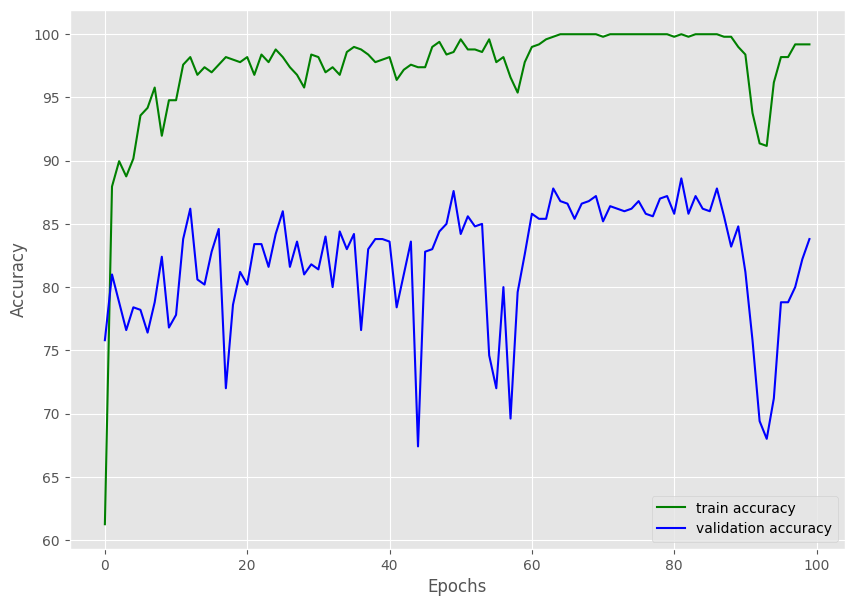

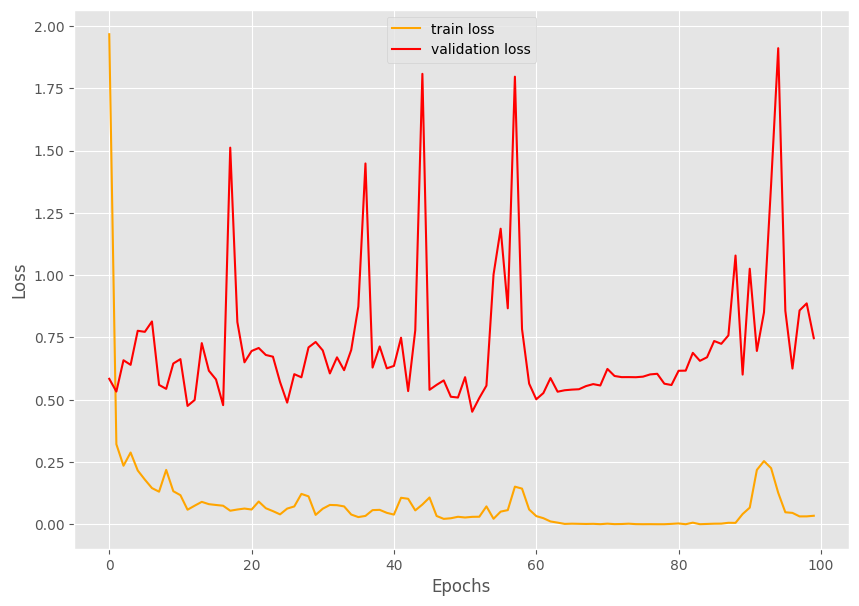

In [ ]:
plt.figure(figsize=(10, 7))
plt.plot(train_accuracy, color='green', label='train accuracy')
plt.plot(val_accuracy, color='blue', label='validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.figure(figsize=(10, 7))
plt.plot(train_loss, color='orange', label='train loss')
plt.plot(val_loss, color='red', label='validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()